In [1]:
import numpy as np

import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from scipy import interpolate
from keras.models import load_model

from icecream import ic

import matplotlib.pyplot as plt

ic.configureOutput(prefix="", outputFunction=print)

In [2]:
ic(keras.__version__)
ic(tensorflow.__version__)
print("")

keras.__version__: '2.11.0'
tensorflow.__version__: '2.11.0'



In [3]:
# generate synthetic data for a simple function: x**2, but with some large offsets
# note: to really do some NN trainings and validation, should also ideally generate a "validation" set not seen during training to test
# on unseen data, but this is not the point here

x_offset = 497.5
x_scaling = 2.0
y_offset = 0.0
y_scaling = 1.0

n_points_train = int(1e4)
n_points_val = int(1e3)

x_train = np.random.normal(x_offset, x_scaling, (n_points_train))

y_train = y_scaling * ((x_train - x_offset)**2) + y_offset

x_train = x_train.squeeze()
y_train = y_train.squeeze()

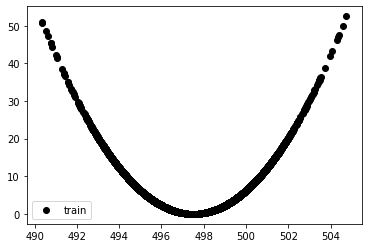

In [4]:
# how the training data look like

plt.figure()
plt.scatter(x_train, y_train, color="k", label="train")
plt.legend()
plt.show()

In [5]:
# normalization layers

predictors_normalization_layer = layers.Normalization(input_shape=[1,], axis=None)
predictors_normalization_layer.adapt(x_train)

np.mean((y_train-y_mean)/y_std): -3.730349362740526e-18
np.std((y_train-y_mean)/y_std): 1.0

illustrate input normalization
np.mean(predictors_normalization_layer(x_train)): 2.4915791e-05
np.std(predictors_normalization_layer(x_train)): 0.9999996



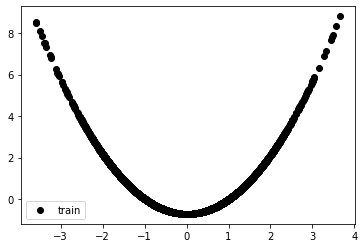

In [6]:
# illustrate the normalization layers
# the input layers moves the input distribution to something close to N(0, 1)
# the x_train -> mean 0, std 1
# the output layer denormalization moves N(0, 1) to something close to the output distribution
# mean 0, std 1 y -> true data mean, true data std

y_mean = np.mean(y_train)
y_std = np.std(y_train)

ic(np.mean((y_train-y_mean)/y_std))
ic(np.std((y_train-y_mean)/y_std))

print("")

print("illustrate input normalization")
ic(np.mean(predictors_normalization_layer(x_train)))
ic(np.std(predictors_normalization_layer(x_train)))

print("")

# as seen by the internal layers of the ANN
plt.figure()
plt.scatter(predictors_normalization_layer(x_train), ((y_train-y_mean)/y_std), color="k", label="train")
plt.legend()
plt.show()


In [7]:
# define a simple model for a network, including the normalization layers

input_layer = keras.layers.Input(shape=(1, ))
normalized_input = predictors_normalization_layer(input_layer)
fully_connected_1 = keras.layers.Dense(80, activation="relu")(normalized_input)
fully_connected_2 = keras.layers.Dense(80, activation="relu")(fully_connected_1)
output = keras.layers.Dense(1)(fully_connected_2)
denormalized_output = output

# metaparameters
learning_rate = 1e-1
epochs = int(1e2)
min_delta_stop = 1e-4
patience_stop = 5

# model
keras_model = keras.Model(inputs=input_layer, outputs=denormalized_output)
keras_model.compile(optimizer=keras.optimizers.Adagrad(learning_rate=learning_rate), loss="mean_absolute_error")
keras_model.summary()
path_checkpoint = "./residual_learning_checkpoint.tf"

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 normalization (Normalizatio  (None, 1)                3         
 n)                                                              
                                                                 
 dense (Dense)               (None, 80)                160       
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 1)                 81        
                                                                 
Total params: 6,724
Trainable params: 6,721
Non-trainable params: 3
___________________________________________________________

In [8]:
# training config
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=min_delta_stop, patience=patience_stop)

model_ckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=False,
    save_best_only=True,
)


# perform learning
history = keras_model.fit(
    x=x_train,
    y=y_train,
    epochs=epochs,
    validation_split=0.10,
    callbacks=[es_callback,],
)

print()
print("done!")

Epoch 1/100
282/282 [==============================] - 2s 3ms/step - loss: 0.5597 - val_loss: 0.6062
Epoch 2/100
282/282 [==============================] - 1s 2ms/step - loss: 0.1770 - val_loss: 0.1821
Epoch 3/100
282/282 [==============================] - 1s 2ms/step - loss: 0.1307 - val_loss: 0.0470
Epoch 4/100
282/282 [==============================] - 1s 2ms/step - loss: 0.1025 - val_loss: 0.1521
Epoch 5/100
282/282 [==============================] - 1s 2ms/step - loss: 0.0909 - val_loss: 0.2062
Epoch 6/100
282/282 [==============================] - 1s 3ms/step - loss: 0.0809 - val_loss: 0.0509
Epoch 7/100
282/282 [==============================] - 1s 2ms/step - loss: 0.0716 - val_loss: 0.0527
Epoch 8/100
282/282 [==============================] - 1s 2ms/step - loss: 0.0652 - val_loss: 0.0248
Epoch 9/100
282/282 [==============================] - 1s 3ms/step - loss: 0.0622 - val_loss: 0.0691
Epoch 10/100
282/282 [==============================] - 1s 2ms/step - loss: 0.0575 - val_lo

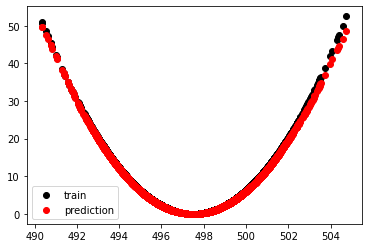

In [9]:
nn_prediction_training = np.array(keras_model(x_train)).squeeze()
plt.figure()
plt.scatter(x_train, y_train, color="k", label="train")
plt.scatter(x_train, nn_prediction_training, color="r", label="prediction")
plt.legend()
plt.show()

In [10]:
# dump and reload
keras_model.save("./saved_models/keras_model_1")
del keras_model
keras_model = load_model("./saved_models/keras_model_1")

INFO:tensorflow:Assets written to: ./saved_models/keras_model_1/assets


INFO:tensorflow:Assets written to: ./saved_models/keras_model_1/assets


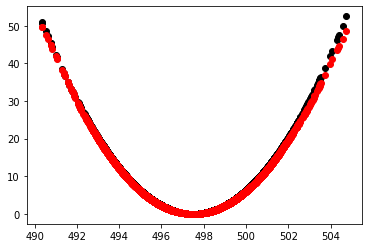

In [11]:
# we should get the exact same results, but now things do not work

nn_prediction_training = np.array(keras_model(x_train)).squeeze()

plt.figure()
plt.scatter(x_train, y_train, color="k")
plt.scatter(x_train, nn_prediction_training, color="r")
plt.show()